In [1]:
import numpy as np
import math
import time
import sys
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
test = np.load('/home/urimi1204/data_block.npy')

data = test[90]
data = data.astype(np.uint16)
print(len(data))
print(data)

32
[  0 189  61  62 188 190 190 190   0 238 230 169 186  51  97 143   0  74  70 153 173 200  65 100   0 192  16 132 192  16  96  44]


In [2]:
# N words of M bit
#             M   bit
#    [[                      ]
# N   [                      ]
#     [                      ]
# w   [                      ]
# o   [                      ]
# r             ...
# d   [                      ]
# s   [                      ]
#     [                      ]
#     [                      ]
#     [                      ]]
N = 16
M = 16
datatype = 'uint16'

## 일단 N은 태원이 형이 준 파일이 넘피 어레이에 인자가 32개짜리라서 32로 지정해놨구요, 나머지도 변수로 지정해놨으니까 나중에 변경될 수 있다 정도만 파악해두셔도 될거같아요

In [3]:
# decimal int number to binary numpy array
def toBinary(value, width):
    value_bin = np.binary_repr(value, width = width)
    # width가 자릿수, value가 바꿀 정수
    
    value_bin = np.array(list(value_bin))
    value_bin = value_bin.astype(datatype)
    return value_bin

In [4]:
a = -128
print(toBinary(a, N))

[1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [5]:
# binary numpy array to decimal int number
def toDecimal(nparr):
    fliarr = np.flip(nparr)
    # 들어온 넘피 어레이의 끝자리부터 2곱해서 더해줄려고 1차원 넘피 어레이를 뒤집어주는 함수
    # ex) [0 0 0 0 0 1] => [1 0 0 0 0 0]
    
    twoarr = np.array([2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9,2**10,2**11,2**12,2**13,2**14,2**15], dtype = np.uint16)
    valuearr = fliarr * twoarr[0:len(fliarr)]
    value = valuearr.sum()
    return value

#for 문 없애는거 가능할 듯? //우림

In [6]:
b = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1], dtype = datatype)
print(toDecimal(b))
print(b.sum())

65535
16


In [7]:
#uint8 두개를 합쳐서 uint 16으로 만들기
#uint8 두개의 순서는 [LSB, MSB]
def DataManipulation(datablock):
    new_datablock = datablock.reshape(-1,2)
    mul_arr = np.array([1, 2**8], dtype = datatype).reshape(-1, 2)
    mul_arr = np.repeat(mul_arr, repeats = new_datablock.shape[0], axis = 0)
    ret_datablock = new_datablock * mul_arr
    ret_datablock = ret_datablock.sum(axis = 1)
    return ret_datablock

In [8]:
new_data = DataManipulation(data)
print(new_data)

[48384 15933 48828 48830 60928 43494 13242 36705 18944 39238 51373 25665 49152 33808  4288 11360]


In [9]:
# make bit vector, non zero data
def BitVector(datablock):
    bit_vec = np.zeros(N, dtype = datatype)
    # N개의 0으로 이루어진 1차원 넘피 어레이 생성
    
    zero_position = np.where(datablock == 0)[0]
    bit_vec[zero_position] = 1
    # 0인 위치를 1로 기록
    
    nonzerodata = datablock[np.where(datablock != 0)]
    return bit_vec, nonzerodata

In [10]:
bitvector, non_zero_data = BitVector(new_data)
print(bitvector)
print(non_zero_data)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[48384 15933 48828 48830 60928 43494 13242 36705 18944 39238 51373 25665 49152 33808  4288 11360]


In [11]:
## Delta 구할 때 signbit 필요없다고 하십니다! 16bit 위로 넘치는 bit는 잘라도 된다고 합니다.

def Delta(datablock):
    baseword = datablock[0]
    delta = np.diff(datablock.astype(np.uint16))
    #sign_bit = np.zeros(len(datablock)-1, dtype = datatype)
    #sign_pos = np.where(delta < 0)
    
    #sign_bit[sign_pos] = 1
    #delta[sign_pos] += 2**(M)
    
    delta = delta.astype(datatype)
    
    return baseword, delta

In [12]:
baseword, delta= Delta(non_zero_data)
print(baseword)
print(delta)

48384
[33085 32895     2 12098 48102 35284 23463 47775 20294 12135 39828 23487 50192 36016  7072]


In [13]:
# compress base word
def BaseSymbol(word):
    if word == 0:
        symbol = np.array([0, 0, 0], dtype=datatype)
        word = np.array([], dtype=datatype)
        # 빈 어레이를 만들어서 반납, 빈 어레이의 길이는 0입니다.
    elif word < 16:
        symbol = np.array([0, 0, 1], dtype=datatype)
        word = toBinary(word, 4)
    elif word < 2**8:
        symbol = np.array([0, 1, 0], dtype=datatype)
        word = toBinary(word, 8)
    else:
        symbol = np.array([1], dtype=datatype) #압축 
        word = toBinary(word, 16)
        
    symbol = np.concatenate((symbol, word), axis=None)
    return symbol

In [14]:
basesymbol = BaseSymbol(0)
print(basesymbol)
print(toBinary(0, 16)) ## 압축 됨
print()

basesymbol = BaseSymbol(1)
print(basesymbol)
print(toBinary(1, 16)) ## 압축 됨
print()

basesymbol = BaseSymbol(63)
print(basesymbol)
print(toBinary(63, 16)) ## 압축 됨
print()

basesymbol = BaseSymbol(6666)
print(basesymbol)
print(toBinary(6666, 16)) ## 16비트로 나타내야 하는 수는 동일한 크기

# 디코더 짤때를 생각해보면, base가 압축 불가능할때는 앞에 1을 붙여줘야 압축된 애들이랑 구분이 가능해져서 수정했어요

[0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0 0 1 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

[0 1 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]

[1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0]


In [15]:
# change to bit plane
def DBP16(deltablock):
    deltas = np.empty((0,M)) ## 빈어레이를 만들지만 2차원으로 만들기 위해서는 크기를 지정해줘야합니다.
    #print(deltas)
    
    for i in range(len(deltablock)):
        delta = toBinary(deltablock[i], M)
        deltas = np.append(deltas, np.array([delta]), axis=0)
    deltas = deltas.astype(datatype)
    #print(deltas) ## delta 값 하나하나 toBinary 함수로 바꿔주면서 빈 어레이에 추가, 이때 toBinary로 리턴한 값이 넘피 어레이라서 append 함수로 추가
    
    dbps = np.array(list(zip(*deltas[::]))) ## 2차원 넘피 어레이를 90도 회전시키는 함수
    #dbps = np.vstack([sign_bit, dbps])      ## sign bit 붙이는 함수
    return dbps

In [16]:
dbps16 = DBP16(delta)
print(dbps16)
print(dbps16.shape)

[[1 1 0 0 1 1 0 1 0 0 1 0 1 1 0]
 [0 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
 [0 0 0 1 1 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0 1 1 0 0 1]
 [0 0 0 1 1 1 1 1 1 1 1 1 0 1 1]
 [0 0 0 1 0 0 0 0 1 1 0 0 1 1 0]
 [0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]
 [1 0 0 1 1 1 1 0 1 1 1 1 0 0 1]
 [0 0 0 0 1 1 1 1 0 0 1 1 0 1 1]
 [0 1 0 1 1 1 0 0 1 1 0 0 0 0 0]
 [1 1 0 0 1 0 1 0 0 1 0 1 0 1 1]
 [1 1 0 0 0 1 0 1 0 0 1 1 1 1 0]
 [1 1 0 0 0 0 0 1 0 0 0 1 0 0 0]
 [1 1 0 0 1 1 1 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 0 1 1 1 1 0 1 0 0 0]
 [1 1 0 0 0 0 1 1 0 1 0 1 0 0 0]]
(16, 15)


In [17]:
# calculate to delta-bit plane-xor
def DBX16(dbps):
    x1 = np.delete(dbps, 0, 0).astype(np.uint16)
    x2 = np.delete(dbps, dbps.shape[0] - 1, 0).astype(np.uint16)
    xored = x1 ^ x2
    xored = np.vstack([dbps[0], xored])
    return xored


## 이 함수는 우림씨 편한대로 바꾸시면 될거같아요

In [18]:
dbxs16 = DBX16(dbps16)
print(dbxs16)
print(dbxs16.shape)

[[1 1 0 0 1 1 0 1 0 0 1 0 1 1 0]
 [1 1 0 0 1 1 1 1 1 0 1 1 0 1 0]
 [0 0 0 1 1 0 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 0 0 1 0 0 1 1 1 0 0 1]
 [0 0 0 1 0 1 0 0 1 1 0 0 0 1 0]
 [0 0 0 0 1 1 1 1 0 0 1 1 1 0 1]
 [0 0 0 0 1 0 1 1 0 0 1 1 1 1 1]
 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 1 1 0 0 0 1 0]
 [0 1 0 1 0 0 1 1 1 1 1 1 0 1 1]
 [1 0 0 1 0 1 1 0 1 0 0 1 0 1 1]
 [0 0 0 0 1 1 1 1 0 1 1 0 1 0 1]
 [0 0 0 0 0 1 0 0 0 0 1 0 1 1 0]
 [0 0 0 0 1 1 1 0 1 1 1 0 0 0 0]
 [1 0 1 1 0 1 0 0 0 0 1 0 0 0 0]
 [1 0 1 1 1 0 0 0 1 0 0 0 0 0 0]]
(16, 15)


In [19]:
patt0 = np.array([0, 0, 0, 0, 0, 0, 0], dtype = np.int64) ## 압축 패턴 카운트 용

'\ndbx_2 = np.empty((0,2))\ndbx_3 = np.empty((0,3))\ndbx_4 = np.empty((0,4))\ndbx_5 = np.empty((0,5))\ndbx_6 = np.empty((0,6))\ndbx_7 = np.empty((0,7))\ndbx_8 = np.empty((0,8))\ndbx_9 = np.empty((0,9))\ndbx_10 = np.empty((0,10))\ndbx_11 = np.empty((0,11))\ndbx_12 = np.empty((0,12))\ndbx_13 = np.empty((0,13))\ndbx_14 = np.empty((0,14))\ndbx_15 = np.empty((0,15))\n'

In [20]:
# make symbols for one DBX plane
def Encoder(dbp, dbx, delta):
    
    global patt0
    
    # if DBX plane is all 1 or all 0
    if np.all(dbx==0):
        patt0[0] += 1 ## 압축 패턴 카운트 용
        return 2, np.array([0, 1], dtype = datatype)
    elif np.all(dbp==0):
        patt0[2] += 1 ## 압축 패턴 카운트 용
        return 5, np.array([0, 0, 0, 0, 1], dtype = datatype)
    elif np.all(dbx==1):
        patt0[1] += 1 ## 압축 패턴 카운트 용
        return 5, np.array([0, 0, 0, 0, 0], dtype = datatype)
    
    # plane is not all 1 or all 0
    pos_one = np.where(dbx == 1)[0]
    
    # single 1
    if len(pos_one) == 1:
        patt0[4] += 1 ## 압축 패턴 카운트 용
        return 5 + math.ceil(math.log2(len(delta)-1)), np.concatenate((np.array([0, 0, 0, 1, 1], dtype = datatype), toBinary(pos_one[0], math.ceil(math.log2(len(delta)-1)))))
    
    
    elif len(pos_one) == 2:
        # Consecutive two 1 연속된 1
        if pos_one[1] - pos_one[0] == 1:
            patt0[3] += 1 ## 압축 패턴 카운트 용
            return 5 + math.ceil(math.log2(len(delta)-2)), np.concatenate((np.array([0, 0, 0, 1, 0], dtype = datatype), toBinary(pos_one[0], math.ceil(math.log2(len(delta)-2)))))
        
        # 연속되지 않은 1 => not compress
        else:
            patt0[6] += 1 ## 압축 패턴 카운트 용
            return len(delta)+1, np.concatenate((np.array([1], dtype=datatype), dbx))
        
    else:
        patt0[5] += 1 ## 압축 패턴 카운트 용
        
        
        return len(delta)+1, np.concatenate((np.array([1], dtype=datatype), dbx))

In [21]:
for i in range(M):
    length, code = Encoder(dbps16[i], dbxs16[i], delta)
    print(dbxs16[i], "->", length, code)

[1 1 0 0 1 1 0 1 0 0 1 0 1 1 0] -> 16 [1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0]
[1 1 0 0 1 1 1 1 1 0 1 1 0 1 0] -> 16 [1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0]
[0 0 0 1 1 0 1 1 1 1 0 1 1 0 0] -> 16 [1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0]
[0 0 0 1 0 0 1 0 0 1 1 1 0 0 1] -> 16 [1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1]
[0 0 0 1 0 1 0 0 1 1 0 0 0 1 0] -> 16 [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0]
[0 0 0 0 1 1 1 1 0 0 1 1 1 0 1] -> 16 [1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1]
[0 0 0 0 1 0 1 1 0 0 1 1 1 1 1] -> 16 [1 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1]
[1 0 0 0 0 1 0 1 0 0 0 0 0 0 0] -> 16 [1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0]
[1 0 0 1 0 0 0 1 1 1 0 0 0 1 0] -> 16 [1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0]
[0 1 0 1 0 0 1 1 1 1 1 1 0 1 1] -> 16 [1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1]
[1 0 0 1 0 1 1 0 1 0 0 1 0 1 1] -> 16 [1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1]
[0 0 0 0 1 1 1 1 0 1 1 0 1 0 1] -> 16 [1 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1]
[0 0 0 0 0 1 0 0 0 0 1 0 1 1 0] -> 16 [1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0]
[0 0 0 0 1 1 1 0 1 1 1 0 0 0 0] -> 16 [1 0 0 0 0 1 1 1 0 1 1 1 0

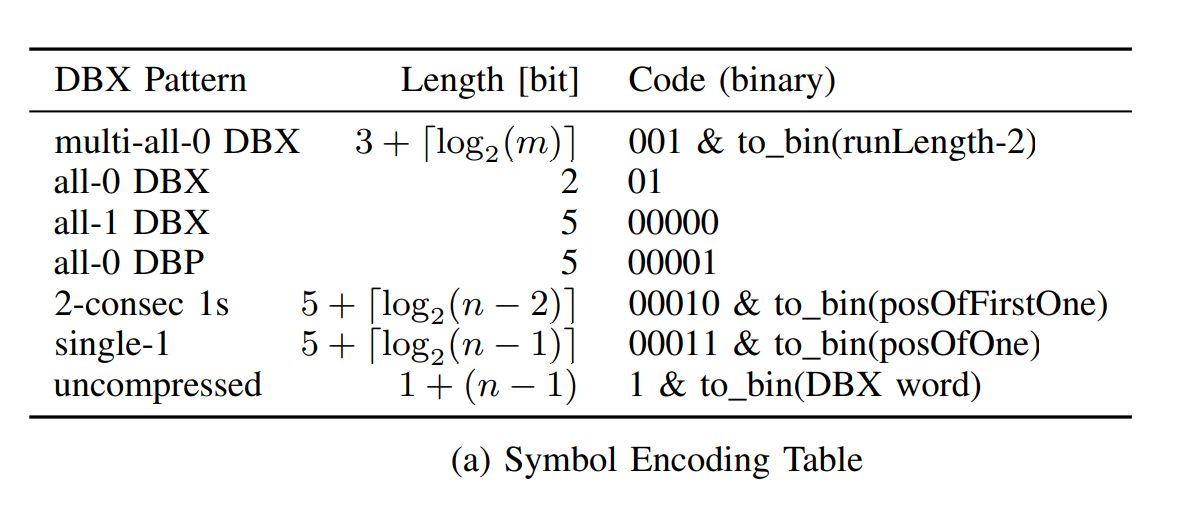

In [22]:
def Packer1(block):
    outputcode = np.array([], dtype=datatype)
    outputlen = 0
    
    new_block = DataManipulation(block)
    bitvector, non_zero_data = BitVector(new_block)
    if len(non_zero_data) == 0:
        basesymbol = BaseSymbol(0)
        dbxs = np.empty(shape = (0,), dtype = datatype)
        dbps = np.empty(shape = (0,), dtype = datatype)
    elif len(non_zero_data) == 1:
        baseword = non_zero_data[0]
        basesymbol = BaseSymbol(baseword)
        dbxs = np.empty(shape = (0,), dtype = datatype)
        dbps = np.empty(shape = (0,), dtype = datatype)
    else:
        baseword, deltablock = Delta(non_zero_data)
        dbps = DBP16(deltablock)
        dbxs = DBX16(dbps)
        basesymbol = BaseSymbol(baseword)
        
        zrl = 0
    
        for i in range(M):
            length, code = Encoder(dbps[i], dbxs[i], delta)

            if np.array_equal(code, np.array([0, 1], dtype = datatype)): # all-0 DBX 일 경우
                zrl += 1
                continue

            else: # all-0 DBX가 아닐 경우
                if zrl != 0: # 근데 앞에 all-0 DBX가 있었을 경우
                    if zrl == 1:
                        outputcode = np.concatenate((outputcode, np.array([0, 1], dtype = datatype)), axis=None)
                        outputlen += 2
                    else:
                        runlen = toBinary(zrl-2, math.ceil(math.log2(M))) ## math.ceil(math.log2(M)) 이건 M을 2진수로 몇비트가 필요한지 나타내는 방법
                        outputcode = np.concatenate((outputcode, np.array([0, 0, 1], dtype=datatype), runlen, code), axis=None)
                        outputlen += 3 + math.ceil(math.log2(len(deltablock))) + length
                    # 이제 all-0 DBX가 아닌 현재 code를 붙여줘야함
                    outputcode = np.concatenate((outputcode, code), axis=None)
                    outputlen += length
                    zrl = 0
                else: # 앞에 all-0 DBX가 없었을 경우
                    outputcode = np.concatenate((outputcode, code), axis=None)
                    outputlen += length
        if zrl != 0:
            runlen = toBinary(zrl-2, math.ceil(math.log2(M)))
            outputcode = np.concatenate((outputcode, np.array([0, 0, 1], dtype=datatype), runlen), axis=None)
            outputlen += 3 + math.ceil(math.log2(len(deltablock)))
        
    outputlen += N + len(basesymbol)
    result = np.concatenate((bitvector, basesymbol, outputcode), axis=None)
    
    # padding
    e = M - len(result)%M
    ex = np.zeros(e, dtype=datatype)
    result = np.concatenate((result, ex), axis=None)
    result = result.reshape((-1, M))
    
    bpcoutput = np.array([], dtype=datatype)
    
    for i in range(len(result)):
        bpcoutput = np.append(bpcoutput, [toDecimal(result[i])], axis=0)
    bpcoutput = np.append(bpcoutput, [outputlen], axis=0)
    
    return bpcoutput, outputlen, dbxs, dbps

In [ ]:
sys.stdout = open("output.txt", "w")
start = time.time()
statis = np.empty((0,))
for idx, blk in enumerate(test):
    if idx > 100:
        break
    blk = blk.astype(np.uint16)
    bpcoutput, output_length, d_dbxs, d_dbps = Packer1(blk)
    bpcoutput = bpcoutput.astype(np.uint16)
    print(f'{idx}\noriginal code \n{blk}\ncompressed code \n{bpcoutput}\n\n')

print(patt0)
print("time :", time.time() - start)

In [ ]:
#순서대로 all-0 DBX, all-1 DBX, all-0 DBP, consec-2 1, single 1, uncompressed, two 1(not consec)